# binary classification example - titanic dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from hyperopt import hp
from hyperopt import tpe

In [4]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
ks.set_option('compute.default_index_type', 'distributed-sequence')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/29 08:52:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/29 08:52:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
    Replace,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    OrdinalEncoder, 
    WOEEncoder,
    OneHotEncoder
)
# binning
from gators.binning import (
    BinRareCategories,
    Binning,
    CustomBinning,
    QuantileBinning,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    PolynomialFeatures,
    ElementaryArithmetics,
    PolynomialObjectFeatures,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
# feature selection
from gators.feature_selection import (
    SelectFromModel,
    InformationValue
)
# model building
from gators.model_building import (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

### with pandas

In [6]:
data = pd.read_parquet('data/titanic.parquet')
data = data.reset_index(drop=True)
y = data['Survived']
X = data.drop('Survived', axis=1)
train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

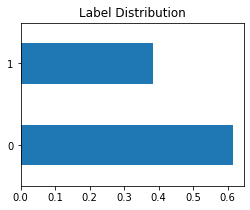

In [8]:
label_counts = data['Survived'].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind='barh', 
    figsize=(4, 3), 
    title='Label Distribution',
);

### offline pipeline - data preprocessing & feature selection

In [9]:
k = 13
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
offline_steps = [
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Name', 'Dummy']),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    NumericsImputer(columns=['Age', 'Fare'], strategy='mean'),
    NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent'),
    ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilitySize']),
    InformationValue(binning=TreeBinning(max_depth=3, inplace=True), k=k)
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
features = list(X_train_prepro.columns)

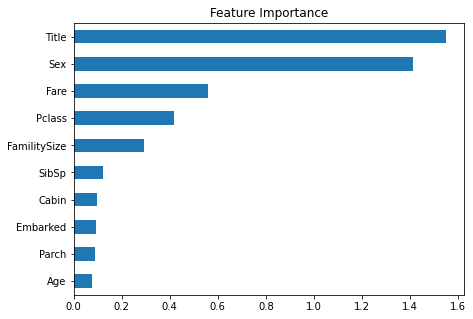

In [10]:
offline_pipe.get_feature_importances(k=15)[::-1].plot(
    kind='barh', 
    figsize=(7, 5), 
    title='Feature Importance',
);

### koalas

In [11]:
data_ks = ks.read_parquet('data/titanic.parquet', index_col='PassengerId')
data_ks = data_ks.reset_index().drop('PassengerId', axis=1)  # important!
y_ks = data_ks['Survived']
X_ks = data_ks.drop('Survived', axis=1)


train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = train_test_split.transform(X_ks, y_ks)


offline_pipe_ks = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe_ks.fit_transform(
    X_train_ks, y_train_ks)

#### check pandas and koalas results match - offline pipeline

In [12]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prepro_ks.to_pandas()
)

## production pipeline

In [13]:
prod_steps = offline_steps = [
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Name', 'Dummy']),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    NumericsImputer(columns=['Age', 'Fare'], strategy='mean'),
    NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent'),
    ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilitySize']),
    KeepColumns(columns_to_keep=features),
    BinRareCategories(min_ratio=0.),
    WOEEncoder(),
]

### pandas

In [14]:
X_train_prod = X_train.copy()
X_train_prod_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())

In [15]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_np),
    pd.DataFrame(X_train_prod_prepro.to_numpy())
)

### koalas

In [16]:
X_train_prod_ks = X_train_ks.copy()
X_train_prod_ks_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())

#### check pandas and koalas results match - production pipeline

In [17]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)
assert_frame_equal(
    X_train_prod_prepro, 
    X_train_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)


## model building

### numpy

In [18]:
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

y_train_np = y_train.to_numpy()
n_splits = 10
max_evals = 100
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 25),
    'max_depth': hp.quniform('max_depth', 2, 3, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
 }
model = XGBClassifier(
    random_state=0, 
    use_label_encoder=False,
)
hyper = HyperOpt(
    model=model,
    algo=tpe.suggest,
    scoring=f1_scoring,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|██████| 100/100 [00:19<00:00,  5.07trial/s, best loss: -0.8343716063037453]


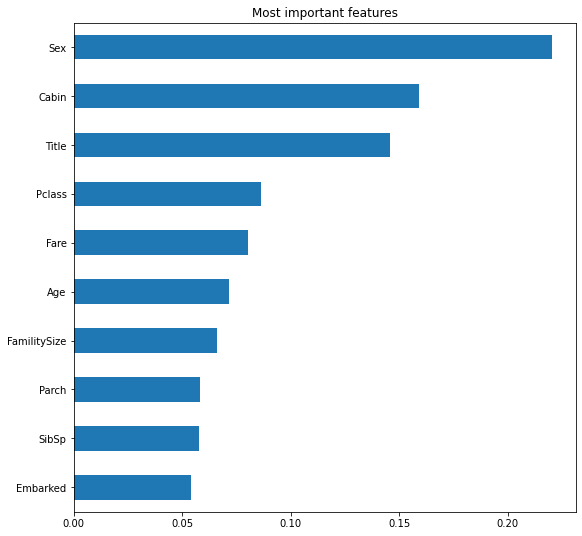

In [19]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [20]:
hyper.history.sort_values('loss')

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,loss,status,id
66,0.546189,0.146771,3.0,175.0,0.263410,-0.834372,ok,66
78,0.411612,0.040889,3.0,150.0,0.901137,-0.831638,ok,78
52,0.508003,0.047284,3.0,175.0,0.384912,-0.830676,ok,52
37,0.696621,0.038157,3.0,200.0,0.559684,-0.830222,ok,37
62,0.661958,0.135223,3.0,175.0,0.269649,-0.830093,ok,62
...,...,...,...,...,...,...,...,...
5,0.344877,0.043136,3.0,125.0,0.386011,-0.807088,ok,5
90,0.237578,0.041055,2.0,175.0,0.437772,-0.803582,ok,90
8,0.242181,0.019879,3.0,150.0,0.608391,-0.801888,ok,8
60,0.267951,0.052637,3.0,175.0,0.201090,-0.801483,ok,60


In [21]:
model_np = copy.copy(hyper.model)
model_path = 'models/model_titanic.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [22]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [23]:
xgb_booster = XGBBoosterBuilder.train(
    model=hyper.model, 
    X_train=X_train_prod_prepro_np, 
    y_train=y_train_np,
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/treelite_xgb_titanic.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_tl = treelite_runtime.Predictor(
    './models/treelite_xgb_titanic.so', verbose=False)

[08:54:02] /Users/travis/build/dmlc/treelite/src/compiler/ast_native.cc:703: Using ASTNativeCompiler
[08:54:02] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:92: Code generation finished. Writing code to files...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file recipe.json...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu3.c...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu2.c...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu1.c...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu0.c...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file header.h...
[08:54:02] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Wri

#### check the models prediction match

In [24]:
X_test_prod = X_test.copy()
X_test_prod_np = X_test_prod.to_numpy()
y_pred_pd = model_pd.predict_proba(
    prod_pipe.transform(X_test_prod))[:, 1]
y_pred_np = model.predict_proba(
    prod_pipe.transform_numpy(X_test_prod_np.copy()))[:, 1]
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, y_pred_tl)

## model evaluation

In [25]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test.copy()
X_test_prod_np = X_test_prod.to_numpy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred):.2f}'

'f1 score: 0.71'

## per-sample bechmarking

### pipeline only

In [26]:
x = X_test_prod.iloc[[0]]
x_np = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(x_np.copy())

11.9 ms ± 96.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
47.1 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x253'

### pipeline & model

In [28]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(x_np.copy()))[0]
stats_tl = %timeit -o  model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(x_np.copy())))

12.3 ms ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
195 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
98.6 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x63'

In [30]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x125'